In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
from copy import deepcopy

from abc import ABC, abstractmethod

In [3]:
from importlib import reload
import logging

reload(logging)
logging.basicConfig(format='[%(asctime)s] %(message)s', datefmt='%Y/%m/%d %H:%M:%S', 
                    level=logging.INFO)

# reload(logging)
# logging.basicConfig(format='[%(asctime)s] %(message)s', datefmt='%Y/%m/%d %H:%M:%S', 
#                     level=logging.DEBUG)

logging.info("Starting Logging")


# logger = logging.getLogger()
# logger.setLevel()

[2022/01/08 16:16:49] Starting Logging


# Actions that players can take

In [4]:
class ActionFold:
    def __init__(self):
        self.id = 0
        self.name = "fold"
        
    def __str__(self):
        return f'Action = ({self.name}, {self.id})'

class ActionCheck:
    def __init__(self):
        self.id = 1
        self.name = "check"
        
    def __str__(self):
        return f'Action = ({self.name})'
    
class ActionCall:
    def __init__(self):
        self.id = 2
        self.name = "call"
        
    def __str__(self):
        return f'Action = ({self.name})'
    
class ActionRaise:
    def __init__(self, amount=1):
        self.id = 3
        self.name = "raise"
        self.amount = amount
        
    def set_amount(self, amount):
        self.amount = amount
        
    def __str__(self):
        return f'Action = ({self.name}: {self.amount})'

# Different Player-Styles

## Base - Player
All players will inherit the BasePlayer

In [5]:
class BasePlayer(ABC):
    ###################################################################################################
    #         CONSTRUCTOR
    ###################################################################################################
    @abstractmethod
    def __init__(self):
        self.hand = None
        self.bankroll = None
    
    ###################################################################################################
    #         GET HAND
    ###################################################################################################
    def get_hand(self, card: int):
        self.hand = card

    ###################################################################################################
    #         GET POSITION
    ###################################################################################################
    def get_position(self, position: int):
        self.position = position
        
    ###################################################################################################
    #         PAY INTO POT
    ###################################################################################################
    def pay_into_pot(self, amount: int):
        self.bankroll -= amount
        
    ###################################################################################################
    #         COLLECT POT
    ###################################################################################################
    def collect_pot(self, amount: int):
        self.bankroll += amount
       
    ###################################################################################################
    #         CHOSE-ACTION
    ###################################################################################################
    @abstractmethod
    def chose_action(self):
        pass

## Player picking actions at random

In [8]:
class PlayerRandomChoice(BasePlayer):
    ###################################################################################################
    #         CONSTRUCTOR
    ###################################################################################################
    def __init__(self,
                 bankroll: int,
                 playerId: int,
                 playerName: str):
        self.bankroll = bankroll
        self.bankroll_initial = bankroll # keep track of bankroll at beginning
        self.playerId = playerId
        self.playerName = playerName
                
    ###################################################################################################
    #         CHOSE THE ACTION FOR PLAYER
    ###################################################################################################
    def chose_action(self, allowed_actions):
        """
        Chose the action for player at random
        """
        actionName = random.choice(allowed_actions)
        
        if actionName == "raise":
            return ActionRaise()
        
        elif actionName == "call":
            return ActionCall()
        
        elif actionName == "check":
            return ActionCheck()
        
        elif actionName == "fold":
            return ActionFold()
        
        raise ValueError("No action found for player")

## Player without any randomness

* always bet/call with best card
* always call with middle card
* always check/fold with worst card

The position of the player is also irrelevant for decision-making

In [9]:
class PlayerDeterministic(BasePlayer):
    ###################################################################################################
    #         CONSTRUCTOR
    ###################################################################################################
    def __init__(self,
                 bankroll: int,
                 playerId: int,
                 playerName: str):
        self.bankroll = bankroll
        self.bankroll_initial = bankroll # keep track of bankroll at beginning
        self.playerId = playerId
        self.playerName = playerName
        
    ###################################################################################################
    #         CHOSE THE ACTION FOR PLAYER
    ###################################################################################################
    def chose_action(self, allowed_actions):
        """
        Chose the action for player:
            Always raise/call with King
            Always call, never bet with Queen
            Always check if possible with Jack, otherwise fold
        """
        if len(allowed_actions) == 1:
            if allowed_actions[0] == "check":
                return ActionCheck()
            else:
                raise RuntimeError("Only possible action is to \"{}\".".format(allowed_actions[0]) + \
                    "This should not happen.")
                
        # ----- player is holding best hand
        if self.hand == "K":
            if "raise" in allowed_actions:
                return ActionRaise()
            
            elif "call" in allowed_actions:
                return ActionCall()
                
            elif "check" in allowed_actions:
                return ActionCheck()
             
        # ----- player is holding second-best hand
        elif self.hand == "Q":
            if "call" in allowed_actions:
                return ActionCall()
                
            elif "check" in allowed_actions:
                return ActionCheck()
        
        # ----- player is holding worst hand
        elif self.hand == "J":
            if "check" in allowed_actions:
                return ActionCheck()
            else:
                return ActionFold()
        
        # ----- player is holding unknown hand
        else:
            raise ValueError(f"Unknown hand: {self.hand}")
            
        raise ValueError("No action found for player")

## Player using Nash Equilibrium 

In [10]:
class PlayerNash(BasePlayer):
    """
    based on: https://en.wikipedia.org/wiki/Kuhn_poker
    """
    ###################################################################################################
    #         CONSTRUCTOR
    ###################################################################################################
    def __init__(self,
                 bankroll: int,
                 playerId: int,
                 playerName: str,
                 alpha: float):
        self.bankroll = bankroll
        self.bankroll_initial = bankroll # keep track of bankroll at beginning
        self.playerId = playerId
        self.playerName = playerName
                
        assert alpha <= 1/3, \
            "alpha must be in  [0, 1/3]"
        self.alpha = alpha
        
    ###################################################################################################
    #         CHOSE THE ACTION FOR PLAYER
    ###################################################################################################
    def chose_action(self, allowed_actions):
        """
        the action taken depends on the position of the player
        """
        
        if len(allowed_actions) == 1:
            if allowed_actions[0] == "check":
                return ActionCheck()
            else:
                raise RuntimeError("Only possible action is to \"{}\".".format(allowed_actions[0]) + \
                    "This should not happen.")
                
        ###############################################################################################
        #         ACTION FOR POSITION 0
        ###############################################################################################
        if self.position == 0:
            # ----- player is holding best hand
            if self.hand == "K":
                if "raise" in allowed_actions:
                    p_raise = random.random()
                    if p_raise <= 3*self.alpha:
                        return ActionRaise()
                    else:
                        return ActionCheck()
                    
                if "call" in allowed_actions:
                    return ActionCall()

            # ----- player is holding second-best hand        
            elif self.hand == "Q":
                if "check" in allowed_actions:
                    return ActionCheck()

                if "call" in allowed_actions:
                    p_call = random.random()
                    if p_call <= (self.alpha+1/3):
                        return ActionCall()
                    else:
                        return ActionFold()
        
            # ----- player is holding worst hand
            elif self.hand == "J":
                if "raise" in allowed_actions:
                    p_raise = random.random()
                    if p_raise <= self.alpha:
                        return ActionRaise()
                    else:
                        return ActionCheck()
                else:
                    return ActionFold()

            # ----- unknown hand
            else:
                raise ValueError(f"Unknown hand: {self.hand}")
                
        ###############################################################################################
        #         ACTION FOR POSITION 1
        ###############################################################################################
        elif self.position == 1:
            # ----- player is holding best hand
            if self.hand == "K":
                if "raise" in allowed_actions:
                    return ActionRaise()
                    
                if "call" in allowed_actions:
                    return ActionCall()

            # ----- player is holding second-best hand        
            elif self.hand == "Q":
                if "check" in allowed_actions:
                    return ActionCheck()

                if "call" in allowed_actions:
                    p_call = random.random()
                    if p_call <= 1/3:
                        return ActionCall()
                    else:
                        return ActionFold()
        
            # ----- player is holding worst hand
            elif self.hand == "J":
                if "check" in allowed_actions:
                    return ActionCheck()
                else:
                    return ActionFold()

            # ----- unknown hand
            else:
                raise ValueError(f"Unknown hand: {self.hand}")
                
        ###############################################################################################
        #         ACTION FROM UNKNOWN POSITION
        ###############################################################################################
        else:
            raise RuntimeError("Unknown position for player")
            
        raise ValueError("No action found for player")

# GameManager class

In [68]:
class GameManager:
    ###################################################################################################
    #         CONSTRUCTOR
    ###################################################################################################
    def __init__(self,
                 n_rounds: int,
                 list_players: list,
                 ante: int,
                 list_cards: list):
        self.n_rounds = n_rounds
        self.n_rounds_played = 0
        self.list_players = list_players
        self.n_players = len(list_players)
        assert self.n_players == 2, \
            "Only 2 players supported at the moment"
        self.ante = ante
        self.list_cards = list_cards
        assert len(list_cards) > self.n_players, \
            "len(list_cards) <= n_players"
        
        self.set_playerPositions()
        self.pot = 0
        self.dict_handRank = {"J": 1, "Q": 2, "K": 3}
        
        # logging
        list_names = [player.playerName for player in list_players]
        self.df_bankroll = pd.DataFrame(columns=list_names)
        list_bankroll = [player.bankroll for player in list_players]
        self.df_bankroll.loc[0] = list_bankroll
        
        self.gameWinner = None
        self.winnerBankroll = None
      
    ###################################################################################################
    #         PLAY THE GAME
    ###################################################################################################
    def play(self):
        logging.info("")
        logging.info("Starting to play the game")
        gameOver = False
        
        for i_round in range(1, self.n_rounds+1):
            logging.debug(f"Playing round {i_round}")
            self.n_rounds_played = i_round
            self.pot = 0
            self.players_allIn = []
            
            # initial admin to set up the round
            self.update_playerPositions()
            self.collect_ante(self.ante)
            self.find_playersAllIn(self.list_players)
            
            self.deal_cards()
            
            # start the betting round
            round_isOpen = True
            currentPlayer = self.playerPositions[0]
            if len(self.players_allIn) > 0:
                allowed_actions = ["check"]
                if self.n_players > 2:
                    raise NotImplementedError("This logic does not work for 3+ players")
            else:
                allowed_actions = ["check", "raise"]
                
            amountToCall = 0
            nChecks = 0
            players_notFolded = deepcopy(self.playerPositions)
            
            while round_isOpen:
                action = self.list_players[currentPlayer].chose_action(allowed_actions)
                logging.debug("   Player \"{}\" chose: {}".format(
                    self.list_players[currentPlayer].playerName, action))
                            
                # sanity check: ensure player has the money they committed
                if action.name == "call":
                    if self.list_players[currentPlayer].bankroll < amountToCall:
                        raise RuntimeError("Player tried to call, but had insufficient funds")
                elif action.name == "raise":
                    if self.list_players[currentPlayer].bankroll < action.amount:
                        raise RuntimeError("Player tried to raise, but had insufficient funds")
                    
                if action.name == "fold":
                    players_notFolded.remove(currentPlayer)
                    round_isOpen = False  
                    
                elif action.name == "check":
                    nChecks += 1
                    # if all players checked: round is over
                    if nChecks == self.n_players:
                        round_isOpen = False
                
                elif action.name == "call":
                    self.list_players[currentPlayer].pay_into_pot(amountToCall)
                    self.pot += amountToCall
                    round_isOpen = False
                    
                elif action.name == "raise":
                    self.list_players[currentPlayer].pay_into_pot(action.amount)
                    self.pot += action.amount
                    
                    amountToCall = action.amount
                    allowed_actions = ["fold", "call"]
                    
                else:
                    raise ValueError("Unknown action chosen: ", action.name)
                    
                # move to next player
                currentPlayer += 1
                currentPlayer = currentPlayer % self.n_players
            
            # find the winner
            assert len(players_notFolded) >= 1, \
                "All players folded"    
            winningPlayer, winningHand = self.find_winningPlayer(players_notFolded)

            logging.debug("The winning player is {}. pot won = {}".format(
                self.list_players[winningPlayer].playerName, self.pot))
            
            # pay the winner
            self.list_players[winningPlayer].collect_pot(self.pot)
            
            # logging
            list_bankroll = [player.bankroll for player in self.list_players]
            self.df_bankroll.loc[i_round] = list_bankroll
            
            logging.debug("Updated game status:")
            for player in self.list_players:
                logging.debug("   {} bankroll = {}".format(player.playerName, player.bankroll))
            
            logging.debug(f"Round {i_round} completed\n")
            
            # make sure all players still have positive bankroll
            for player in self.list_players:
                if player.bankroll < 0:
                    raise RuntimeError("Something went wrong: {} has negative bankroll {}".format(
                        player.playerName, player.bankroll))
                    
                if player.bankroll == 0:
                    logging.info("Game over, player {} ran out of money".format(player.playerName))
                    gameOver = True
                    break
                    
            if gameOver:
                break
        
        logging.info("The game finished")
        logging.info("   Rounds played: {}".format(i_round))
        
        for i, p in enumerate(self.list_players):
            logging.info("   {} --> {}".format(p.playerName, p.bankroll))
            if self.gameWinner is None:
                self.gameWinner = i
                self.winnerBankroll = p.bankroll
            else:
                if p.bankroll > self.winnerBankroll:
                    self.gameWinner = i
                    self.winnerBankroll = p.bankroll
        logging.info("   Player {} won".format(self.list_players[self.gameWinner].playerName))
        
        self.evaluate_playes()
         
    ###################################################################################################
    #         SET PLAYER POSITIONS
    ###################################################################################################
    def set_playerPositions(self):
        self.playerPositions = []
        for playerPosition in range(self.n_players):
            self.playerPositions.append(playerPosition)
            
            # set player's knowledge about their positions
            self.list_players[playerPosition].get_position(playerPosition)
    
    ###################################################################################################
    #         UPDATE PLAYER POSITIONS
    ###################################################################################################
    def update_playerPositions(self):
        for i in range(len(self.playerPositions)):
            newPosition = (self.playerPositions[i] + 1) % self.n_players
            self.playerPositions[i] = newPosition 
            
            # update player's knowledge about their positions
            self.list_players[i].get_position(newPosition)
           
    ###################################################################################################
    #         COLLECT PLAYER ANTE
    ###################################################################################################
    def collect_ante(self, ante: int):
        for idx_player in self.playerPositions:
            self.list_players[idx_player].pay_into_pot(ante)
            self.pot += ante
         
    ###################################################################################################
    #         FIND PLAYERS THAT ARE ALL-IN
    ###################################################################################################
    def find_playersAllIn(self, list_players: list):
        for idx, p in enumerate(list_players):
            if p.bankroll == 0:
                self.players_allIn.append(idx)      
    
    ###################################################################################################
    #         DEAL CARDS TO PLAYERS
    ###################################################################################################
    def deal_cards(self):
        cards_drawn = random.sample(self.list_cards, 2)
        for idx_player in self.playerPositions:
            self.list_players[idx_player].get_hand(cards_drawn[idx_player])
            logging.debug("   {} got the card {}".format(
                self.list_players[idx_player].playerName, cards_drawn[idx_player]))
          
    ###################################################################################################
    #         FIND WINNING PLAYER
    ###################################################################################################
    def find_winningPlayer(self, players_notFolded: list):
        winningPlayer = None
        winningHand = None
        for player in players_notFolded:
            if winningPlayer is None:
                winningPlayer = player
                winningHand = self.list_players[player].hand
            else:
                playerHand = self.list_players[player].hand
                isBetterHand = self._compare_hands(winningHand, playerHand)
                
                if isBetterHand:
                    winningPlayer = player
                    winningHand = playerHand
                    
        return winningPlayer, winningHand 
        
    ###################################################################################################
    #         COMPARE HANDS OF PLAYERS
    ###################################################################################################
    def _compare_hands(self, winningHand: str, playerHand: str):
        rank_winningHand = self.dict_handRank[winningHand]
        rank_playerHand = self.dict_handRank[playerHand]
        if rank_winningHand > rank_playerHand:
            return False
        else:
            return True
        
    ###################################################################################################
    #         EVALUATE THE PLAYER PERFORMANCE
    ###################################################################################################
    def evaluate_playes(self):
        """
        evaluate the performance for the players
            (+) avergage: winningPerRound
            (+) std: winningPerRound
        """
        # PnL: this is the money lost/gained per round
        self.df_PnL = pd.DataFrame(columns=self.df_bankroll.columns)
        self.avg_winPerRound = []
        self.std_winPerRound = []
        
        for col in self.df_bankroll.columns:
            self.df_PnL[col] = self.df_bankroll[col].shift(-1)-self.df_bankroll[col]
         
            # compute average win per round
            self.avg_winPerRound.append(self.df_PnL[col].mean())
        
            # compute std of win per round
            self.std_winPerRound.append(self.df_PnL[col].std())

# Run multiple games and evaluate players

In [73]:
random.seed(314)
n_repeat = 3
bankroll = 100
n_rounds = 5000

# ids based on location in list_players
dict_winners = {0: 0, 1: 0}
df_avgWinStats = None
list_bankrolls = []

for i in range(n_repeat):
    ###################################################################################################
    #         SET UP THE PLAYERS
    ###################################################################################################
#     # ----- random players
#     player1 = PlayerRandomChoice(
#          bankroll = bankroll,
#          playerId = 0,
#          playerName = "Random1")

#     player2 = PlayerRandomChoice(
#          bankroll = bankroll,
#          playerId = 1,
#          playerName = "Random2")
    
#     # ----- deterministic players
    player1 = PlayerDeterministic(
         bankroll = bankroll,
         playerId = 1,
         playerName = "Deterministic1")
    
#     player2 = PlayerDeterministic(
#          bankroll = bankroll,
#          playerId = 1,
#          playerName = "Deterministic2")
    
    player2 = PlayerNash(
        bankroll = bankroll,
        playerId = 1,
        playerName = "Nash1",
        alpha=0.2)

    ###################################################################################################
    #         PLAY THE GAME
    ###################################################################################################
    list_players = [player1, player2]
    
    game = GameManager(
        n_rounds = n_rounds,
        list_players = list_players,
        ante = 1,
        list_cards = ["J", "Q", "K"])

    game.play()
    
    # store the results of the game-outcome for statistical analysis
    dict_winners[game.gameWinner] += 1
    if df_avgWinStats is None:
        df_avgWinStats = pd.DataFrame(columns=game.df_bankroll.columns)
        df_avgWinStats.loc[i] = game.avg_winPerRound
    else:
        df_avgWinStats.loc[i] = game.avg_winPerRound
    list_bankrolls.append(game.df_bankroll)
    
    ###################################################################################################
    #         CLEANUP
    ###################################################################################################
    #del player1, player2, game
    
logging.info("========= COMPLETE ==========")

[2022/01/08 16:45:52] 
[2022/01/08 16:45:52] Starting to play the game
[2022/01/08 16:45:56] Game over, player Deterministic1 ran out of money
[2022/01/08 16:45:56] The game finished
[2022/01/08 16:45:56]    Rounds played: 2233
[2022/01/08 16:45:56]    Deterministic1 --> 0
[2022/01/08 16:45:56]    Nash1 --> 200
[2022/01/08 16:45:56]    Player Nash1 won
[2022/01/08 16:45:56] 
[2022/01/08 16:45:56] Starting to play the game
[2022/01/08 16:46:04] The game finished
[2022/01/08 16:46:04]    Rounds played: 5000
[2022/01/08 16:46:04]    Deterministic1 --> 55
[2022/01/08 16:46:04]    Nash1 --> 145
[2022/01/08 16:46:04]    Player Nash1 won
[2022/01/08 16:46:04] 
[2022/01/08 16:46:04] Starting to play the game
[2022/01/08 16:46:12] Game over, player Deterministic1 ran out of money
[2022/01/08 16:46:12] The game finished
[2022/01/08 16:46:12]    Rounds played: 4675
[2022/01/08 16:46:12]    Deterministic1 --> 0
[2022/01/08 16:46:12]    Nash1 --> 200
[2022/01/08 16:46:12]    Player Nash1 won
[2022/

In [134]:
dict_winners

{0: 23, 1: 27}

In [55]:
game.list_players[1].get_position(1)

In [45]:
for i in range(game.n_players):
    print(i)

NameError: name 'game' is not defined

<AxesSubplot:>

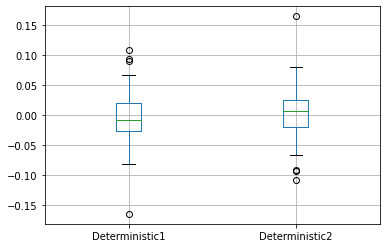

In [135]:
df_avgWinStats.boxplot()

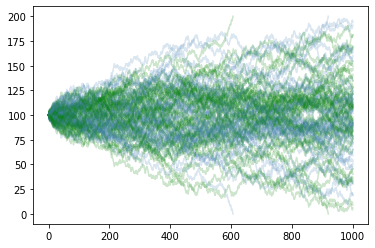

In [137]:
dict_colors = {
    "Random1": "red", 
    "Random2": "darkmagenta",
    "Deterministic1": "steelblue",
    "Deterministic2": "green"}
for df_bankroll in list_bankrolls:
    for p in df_bankroll.columns:
        plt.plot(df_bankroll[p], alpha=0.2, color=dict_colors[p])

In [106]:
len(list_bankrolls)

10

In [95]:
game.df_PnL["Deterministic1"].mean(), game.df_PnL["Deterministic1"].std()

(0.19801980198019803, 1.4407601194610176)